# Skin Disease Classification using Convolutional Neural Networks (CNN)

Analytics and machine learning have many applications in health care, and its potential to transform the way medical practitioners make clinical decisions are becoming more apparent. For this project, we are going to look at identifying skin lesions from dermascopic images. The ability to have automated predictions of which skin lesions are present in an image will greatly assist medical practitioners in their diagnosis, increasing both the speeds and accuracy of diagnosis. Furthermore, we will also highlight regions of the image that explain why the automated predictions makes a particular diagnosis to provide transparency to the algorithm. This is critical to build trust in the predictions in the medical community.
This problem can be divided into two parts:
1. From dermascopic images, determine whether the following diseases are present:
    - Melanoma
    - Melanocytic nevus
    - Basal cell carcinoma
    - Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)
    - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
    - Dermatofibroma
    - Vascular lesion


2. Explain each diagnosis made by the automated prediction, by highlighting regions of each dermascopic image that influences the diagnosis

For this task, we will be using Google Colab. This is a free resource, so feel free to use Google Colab and run this code yourself. I have mounted by google drive to access the files locally.

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

We will also import all the required libraries here.

In [ ]:
# run this then restart kernel if required
! pip install https://github.com/raghakot/keras-vis/archive/master.zip

In [ ]:
 # import required libraries
import pandas as pd
import numpy as np
from zipfile import ZipFile
import random
import math
import os
import pickle
from PIL import Image
from matplotlib import cm
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K

from vis.visualization import visualize_cam, overlay, visualize_saliency
from vis.utils import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

%matplotlib inline

## Data Source

To be able to build a model that can make predictions from images, we will need many dermascopic images which contain the seven diseases of interest, as well as labels for each image identifying which diseases are present.
The image data used is the HAM10000 (Human Against Machine 10,000 training images) dataset, which is a large collection of multi-source dermascopic images of common pigmented skin lesions. For the labels, 50% of the lesions are identified through histopathology, and the remaining are a combination of follow-up examination, expert consensus or confirmation by in-vivo confocal microscopy.

Of the 3000 images, 90% of the images were randomly kept as the training data set, and the remaining 10% were held out as the test data set. The purpose of the test set is purely for a final evaluation of the model performance, and will not be used in any way for the purposes of building the model. It is noted that from the training data, a further split of 80-20% will be made in order to obtain a validation set which will be used for training the model. Whilst k-fold cross validation would produce an even more robust method of evaluating model performance, given the computational resources required, a verification data set to evaluate the model performance during training was determined to be sufficient and adequate.

In [ ]:
# set directory paths
pickled_data = "/content/drive/My Drive/Data Science/skin_cancer_image_data/disease_classification"
image_folder = "/content/drive/My Drive/Data Science/skin_cancer_image_data/disease_classification/scaled_images_2"
label_folder = "/content/drive/My Drive/Data Science/skin_cancer_image_data/disease_classification/ISIC2018_Task3_Training_GroundTruth"

In [ ]:
# Load images and labels
read = lambda img: np.asarray(Image.open(img).convert("RGB"))
img_data = [read(image_folder + "/" + filename) for filename in os.listdir(image_folder) if (".jpg" in filename) and ("scaled" not in filename)]
X = np.array(img_data) / 255

# use pickled data for now
X = pickle.load(open(pickled_data + '/X_mid_sample.pickle', 'rb'))

label_img = pd.read_csv(label_folder + '/ISIC2018_Task3_Training_GroundTruth.csv')
y = label_img.drop(columns='image')
label_col = y.columns
y = np.array(y)

In [ ]:
# Split data into train and test
img_set_size = 3000
test_size = img_set_size * 0.1 # test size

test_idx = math.ceil(X.shape[0]*0.1)

X_test = X[0:test_idx]
X_train = X[test_idx:img_set_size]

y_test = y[0:test_idx]
y_train = y[test_idx:img_set_size]

From the training data, it is prudent to first examine the labelled data to understand the distributions of the skin lesions in our data. Note that we do not look at the distributions in the test data as this may result in leakage during the model building phase (where decisions on the modelling process may be biased from seeing results in the test set).
The plot below shows the distribution of the skin lesions in the training data:

In [ ]:
target_distribution = pd.DataFrame(pd.DataFrame(y_train).sum())
target_distribution.columns = ['count']

target_distribution.loc[0,'skin_lesion'] = 'Melanoma'
target_distribution.loc[1,'skin_lesion'] = 'Melanocytic nevus'
target_distribution.loc[2,'skin_lesion'] = 'Basal cell carcinoma'
target_distribution.loc[3,'skin_lesion'] = 'Actinic keratosis'
target_distribution.loc[4,'skin_lesion'] = 'Benign keratosis'
target_distribution.loc[5,'skin_lesion'] = 'Dermatofibroma'
target_distribution.loc[6,'skin_lesion'] = 'Vascular lesion'

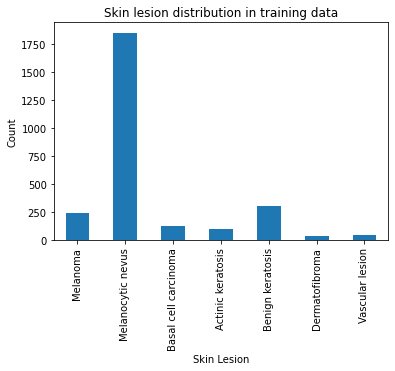

In [ ]:
ax = target_distribution.plot.bar(x='skin_lesion', y='count', rot=90)
ax.set_title('Skin lesion distribution in training data')
ax.set_ylabel('Count')
ax.set_xlabel('Skin Lesion')
ax.get_legend().remove()

We can see that there are many Melanocytic nevus skin lesions, however for the other classes there are few examples. This could result in the model not being able to classify the other skin lesions well, as the general rule of thumb is to have 1000 images for each class. Unfortunately, this is not possible given limited data, however this is something that can be improved for future iterations.

Let us also look at the first 15 images in the training set to have an idea of what they look like.

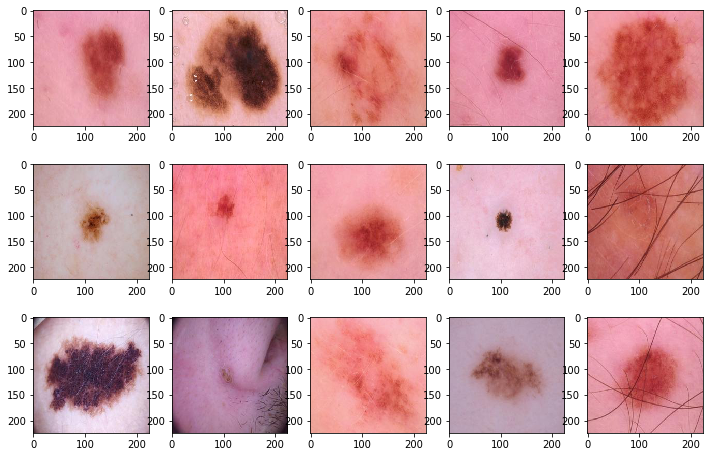

In [ ]:
# Display first 15 images
w=30
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## Model Architecture

A convolutional neural network (CNN) has been used for the skin lesion image classification model. CNN are one of the most used models for image classification. Unlike usual models where the input is simply a number of features, images are more complex in that not only the feature values (i.e. pixels) are important, but also the location of each feature relative to one another. The fact that a red pixel is next to a green pixel is important, not just the fact that an image has these two pixels.

CNNs have convolutional layers, which are able to extract local features by scanning each image input in a grid-like fashion. A filter (set of weights) is applied to an input with repeated overlapping application to generate a feature map. Many convolutional layers are stacked on top of each other, so that the input passes through many filters and learns many different aspects of an image. There are also pooling layers throughout to reduce the dimensionality of the problem. The input is then passed through a fully connected layer to generate an output (which in this case is a predicted skin lesion).

For our skin lesion classification model, a ResNet-50 network has been trained. The ResNet-50 architecture is a 50 layer deep CNN that is commonly used for image classification due to the use of skip connections between layers to solve the vanishing gradient problem (which is when the gradient being back-propagated to earlier layers during training becomes extremely small for deep networks).

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy' 
    ,patience=5 
    ,verbose=1 
    ,factor=0.5 
    ,min_lr=1e-7)

In [ ]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 32

model = ResNet50(
    include_top=True
    ,weights= None
    ,input_tensor=None
    ,input_shape=input_shape
    ,pooling='avg'
    ,classes=7)

model.compile(
    optimizer = Adam(lr) 
    # optimizer = SGD(lr)
    # optimizer = RMSprop(lr)
    ,loss = "categorical_crossentropy"
    ,metrics=["accuracy"])

In [ ]:
history = model.fit(
    X_train, y_train, validation_split=0.2
    ,epochs=epochs, batch_size=batch_size, verbose=2
    ,callbacks=[learning_rate_reduction])

Train on 2160 samples, validate on 540 samples
Epoch 1/50
 - 68s - loss: 3.7889 - accuracy: 0.0167 - val_loss: 2.4081 - val_accuracy: 0.0093
Epoch 2/50
 - 47s - loss: 2.6820 - accuracy: 0.0167 - val_loss: 1.9575 - val_accuracy: 0.0296
Epoch 3/50
 - 47s - loss: 1.9842 - accuracy: 0.0968 - val_loss: 1.7299 - val_accuracy: 0.5463
Epoch 4/50
 - 47s - loss: 1.6284 - accuracy: 0.5833 - val_loss: 1.5663 - val_accuracy: 0.6500
Epoch 5/50
 - 47s - loss: 1.4642 - accuracy: 0.6907 - val_loss: 1.4750 - val_accuracy: 0.6556
Epoch 6/50
 - 47s - loss: 1.3909 - accuracy: 0.6935 - val_loss: 1.4311 - val_accuracy: 0.6556
Epoch 7/50
 - 47s - loss: 1.3396 - accuracy: 0.6935 - val_loss: 1.4251 - val_accuracy: 0.6556
Epoch 8/50
 - 47s - loss: 1.3110 - accuracy: 0.6935 - val_loss: 1.4141 - val_accuracy: 0.6556
Epoch 9/50
 - 47s - loss: 1.2783 - accuracy: 0.6935 - val_loss: 1.4221 - val_accuracy: 0.6556
Epoch 10/50
 - 47s - loss: 1.2630 - accuracy: 0.6935 - val_loss: 1.4236 - val_accuracy: 0.6556

Epoch 00010

Let us look at the validation accuracy and loss as epoch increases.

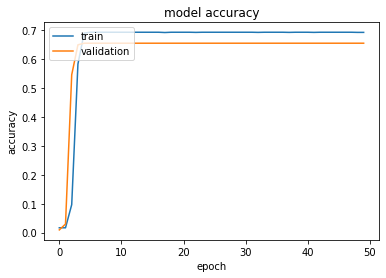

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

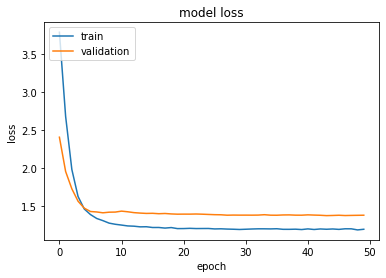

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We will then evaluate the model by looking at the classification report.

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_arg = np.argmax(y_test, axis=1)

print('\nClassification Report\n')
print(classification_report(y_test_arg, y_pred, target_names=[
  'Melanoma'
  ,'Melanocytic nevus'
  ,'Basal cell carcinoma'
  ,'Actinic keratosis'
  ,'Benign keratosis'
  ,'Dermatofibroma'
  ,'Vascular lesion'
]));

![classification_matrix](classification_matrix.PNG)

We can see the model achieves a weighted classification accuracy of 68%. The model seems to perform well for detecting Melanocytic nevus specifically with a recall of 97% and precision of 81%, however the recall for the other diseases are too low to have any practical use. The precision is relatively high for Melanocytic nevus and Basal cell carcinoma, however given the low recall, this will have limited use.

From a medical perspective, it is more important to have higher recall than precision, as it is better to have a false positive than false negative. A potential solution to address this would be to change the classification problem so that a lower threshold is set for the model to flag an image as having a disease, and also to allow multiple labels per image when scoring with the associated probability. This would result in higher recall and lower precision, which would be a better tradeoff for medical applications.

The main area for improvement would be having more data. As a rule of thumb, it is important to have at least 1000 images for each class. Due to data and computational limitations, there were limited data in training set, with only Melanocytic nevus having over 1000 images, thus it is not surprising that only this class performed well. We can also see in the test set there were only 5 and 4 images for Dermatofibroma and Vascular lesion respectively, which is not sufficient to make any confident conclusions on model performance for these classes.

In [ ]:
# save
model.save('model.h5')
model.save_weights('model_weights.h5')

In [ ]:
# load
model_original = keras.models.load_model('model.h5')
model_original.compile(
    optimizer = Adam(lr)
    ,loss="categorical_crossentropy"
    ,metrics=["accuracy"])
model_original.load_weights('model_weights.h5')

In [ ]:
model_original.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## Grad-CAM

The Grad-CAM visualizations for some sample images are shown below (one for each disease, besides Dermatofibroma and Vascular lesion as there were too few cases).

In [ ]:
layer_index = utils.find_layer_idx(model_original, 'activation_147') # get last index layer by name

In [ ]:
# Numbers to visualize
indices_to_visualize = [17, 0, 39, 164, 30]

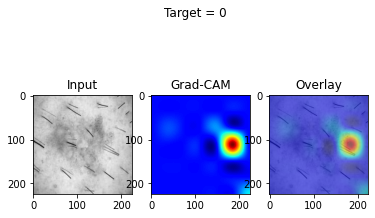

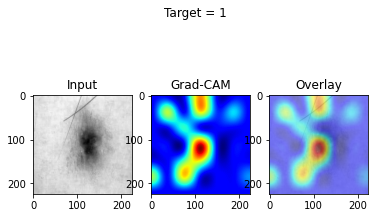

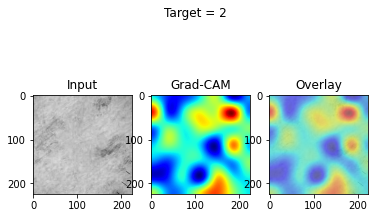

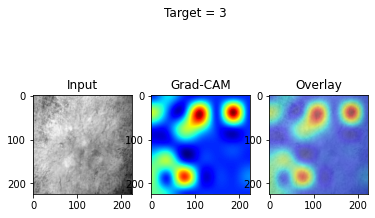

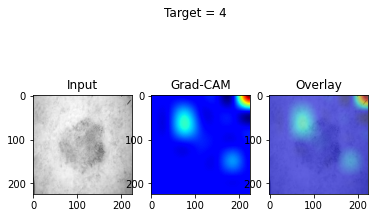

In [ ]:
# Visualize
for index_to_visualize in indices_to_visualize:
  # Get input
  input_image = X_test[index_to_visualize]
  input_class = np.argmax(model_original.predict(np.expand_dims(X_test[index_to_visualize], axis=0)))
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  # Generate visualization
  visualization = visualize_cam(model_original, layer_index, filter_indices=input_class, seed_input=input_image)
  axes[0].imshow(input_image[..., 0], cmap='gray') 
  axes[0].set_title('Input')
  axes[1].imshow(visualization, cmap='jet')
  axes[1].set_title('Grad-CAM')
  heatmap = np.uint8(cm.jet(visualization)[..., :3] * 255)
  original = np.uint8(cm.gray(input_image[..., 0])[..., :3] * 255)
  axes[2].imshow(overlay(heatmap, original), cmap='jet')
  axes[2].set_title('Overlay')
  fig.suptitle(f'Target = {input_class}')
  plt.show()
  # plt.savefig('grad_cam_images_' + str(index_to_visualize) + '.png')

We can see that the Grad-CAM highlighted relevant regions for Target=1 (where red indicates hot spots which influence predictions), however for the other images it is not as clear. This is consistent with the model results, where the model was good at detecting Melanocytic nevus, however performed poorly for the other diseases.

## Conclusion

The final CNN ResNet-50 model for skin lesion classification showed promise for detecting Melanocytic nevus, however it performed poorly for diagnosing other skin lesions. Similarly, for the Grad-CAM visualizations, it was able to highlight relevant regions for Melanocytic nevus however performed poorly for the other classes. Directions for improvement are:

• Using more images for training, particularly for the skin lesions where the model did not perform well

• Specifying a lower threshold for flagging a disease, to achieve higher recall with lower precision, as this is more important for medical diagnosis